# Build a DNN using the Keras Functional API

## Introduction

In this notebook, we will export BigQuery data to Google Cloud Storage to train a Keras model. First, we'll review how to read in CSV file data using `tf.data`. Then, we'll specify input, hidden, and output layers in the DNN architecture. After that, we'll train the model locally and visualize the loss curves. Finally, we'll deploy and predict with the model using Vertex AI.

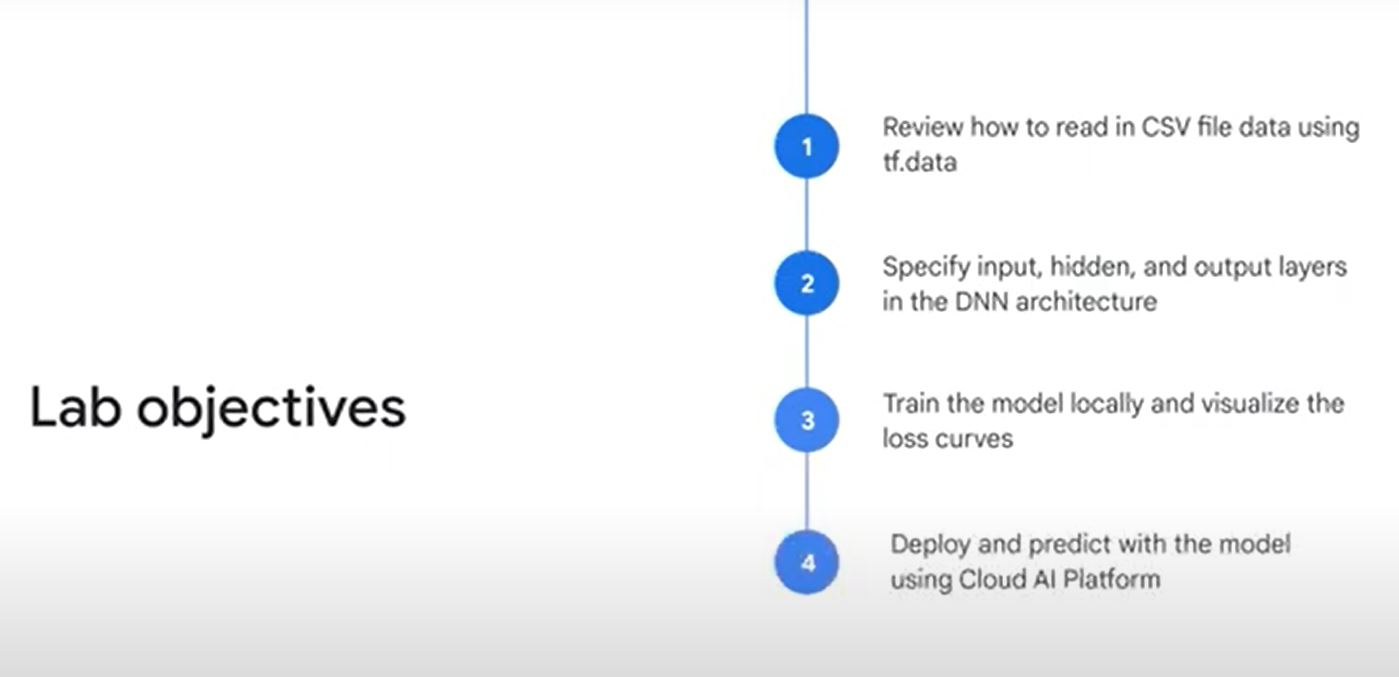


In [1]:
# You can use any Python source file as a module by executing an import statement in some other Python source file
# The import statement combines two operations; it searches for the named module, then it binds the
# results of that search to a name in the local scope.
import os, json, math
# Import data processing libraries like Numpy and TensorFlow
import numpy as np
import tensorflow as tf
# Python shutil module enables us to operate with file objects easily and without diving into file objects a lot.
import shutil
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

2024-01-11 15:05:16.825836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 15:05:16.914312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-11 15:05:16.914325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-11 15:05:16.933721: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 15:05:17.411525: W tensorflow/stream_executor/platform/de

TensorFlow version:  2.10.1


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [3]:
# `ls` is a Linux shell command that lists directory contents
# `l` flag list all the files with permissions and details
!ls -l data/toy_data/*.csv

-rw-r--r-- 1 stephen137 stephen137  61473 Jan  9 20:09 data/toy_data/taxi-test.csv
-rw-r--r-- 1 stephen137 stephen137 288831 Jan  9 20:09 data/toy_data/taxi-train.csv
-rw-r--r-- 1 stephen137 stephen137  61082 Jan  9 20:09 data/toy_data/taxi-valid.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [4]:
# Define columns of data
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [5]:
# Define features you want to use
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [6]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

        # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    # tf.feature_column.numeric_column() represents real valued or numerical features.
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                        

2024-01-11 15:06:06.110031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-11 15:06:06.110442: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-11 15:06:06.110459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-1UDJOCI): /proc/driver/nvidia/version does not exist
2024-01-11 15:06:06.111041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

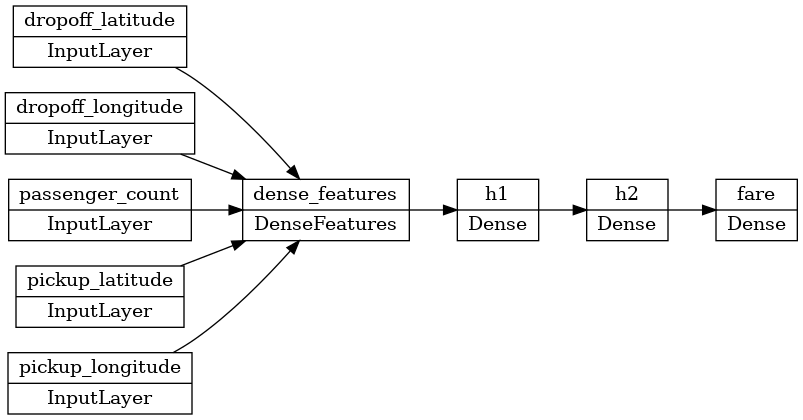

In [7]:
# tf.keras.utils.plot_model() Converts a Keras model to dot format and save to a file.
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [10]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 32  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('data/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('data/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# Model Fit
history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 2s 12ms/step - loss: 192.2276 - rmse: 13.1969 - mse: 192.2276 - val_loss: 96.5765 - val_rmse: 9.8176 - val_mse: 96.5765
Epoch 2/32
48/48 [==============================] - 0s 10ms/step - loss: 85.7770 - rmse: 8.8289 - mse: 85.7770 - val_loss: 95.5762 - val_rmse: 9.7583 - val_mse: 95.5762
Epoch 3/32
48/48 [==============================] - 0s 9ms/step - loss: 83.0519 - rmse: 8.6576 - mse: 83.0519 - val_loss: 97.0927 - val_rmse: 9.8437 - val_mse: 97.0927
Epoch 4/32
48/48 [==============================] - 0s 10ms/step - loss: 80.2398 - rmse: 8.5346 - mse: 80.2398 - val_loss: 95.0599 - val_rmse: 9.7349 - val_mse: 95.0599
Epoch 5/32
48/48 [==============================] - 0s 9ms/step - loss: 82.1209 - rmse: 8.3712 - mse: 82.1209 - val_loss: 93.9660 - val_rmse: 9.6802 - val_mse: 93.9660
Epoch 6/32
48/48 [==============================] - 0s 8ms/step - loss: 79.6922 - rmse: 8.5019 - mse: 79.6922 - val_loss: 87.5788 - val_rmse: 9.3497 - val

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

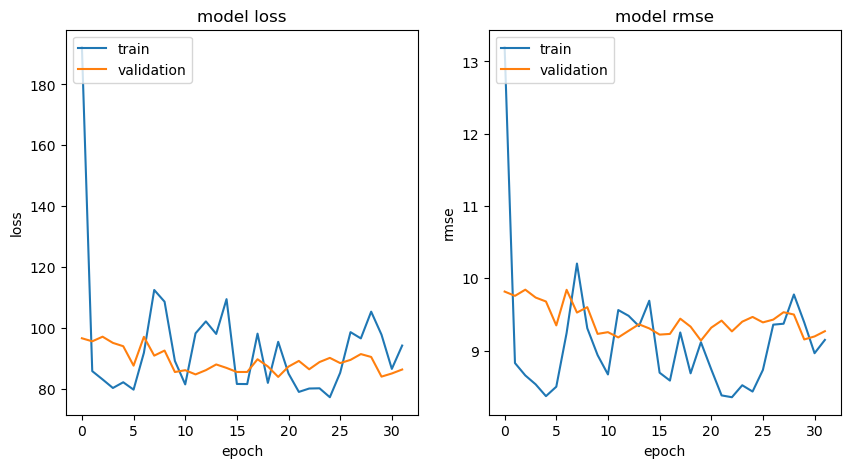

In [11]:
# plot
# Use matplotlib for visualizing the model
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
# The .figure() method will create a new figure, or activate an existing figure.
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
# The .plot() is a versatile function, and will take an arbitrary number of arguments. For example, to plot x versus y.
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
# The .title() method sets a title for the axes.
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
# The .legend() method will place a legend on the axes.
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [12]:
# Use the model to do prediction with `model.predict()`
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

1/1 [==============================] - 0s 83ms/step


array([[18.942963]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.